In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from general_utils import utils
import pickle as pkl
import numpy as np
import importlib
import project_utils.PatientBootstrap as PBS
import os

utils.default_plot_format()

#utils.pd_display_settings(3)


In [15]:
data_path = r'processed_data\raw_metrics\processed_10min_Nabian.pkl'

In [16]:


pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]

data.head()

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,ULF Peak Power,VLF Power,...,Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition,Peak Power,Peak Frequency
1,72044.620,72644.440,50.436358,50.276590,11.294766,72.622536,4.896880e-10,0.001667,3.819060e-07,0.000001,...,0.0,0.0,0.0,False,0.0,0.0,0.0,Diabetes,0.000645,0.181721
2,71444.292,72043.800,44.108359,39.049144,11.699164,71.855928,6.034593e-09,0.000000,4.631651e-06,0.000002,...,0.0,0.0,0.0,False,0.0,0.0,0.0,Diabetes,0.000644,0.178480
3,70844.052,71443.432,64.323347,47.553402,9.686221,73.359897,8.791265e-09,0.000000,7.081658e-06,0.000004,...,0.0,0.0,0.0,False,0.0,0.0,0.0,Diabetes,0.000629,0.176849
4,70243.220,70843.104,111.205365,95.765520,6.415621,71.718719,1.290554e-08,0.001667,8.629014e-06,0.000008,...,0.0,0.0,0.0,False,0.0,0.0,0.0,Diabetes,0.000325,0.365071
5,69642.860,70242.424,89.557078,45.434197,1.664355,72.136039,7.981645e-08,0.001668,4.834561e-05,0.000012,...,0.0,0.0,0.0,False,0.0,0.0,0.0,Diabetes,0.000492,0.308558


In [17]:
print("time_metrics =", time_metrics)
print("frequency_metrics =", frequency_metrics)
print("non_linear_metrics =", non_linear_metrics)

time_metrics = ['SDRR', 'RMSSD', 'pNN50 (%)', 'Mean HR (bpm)']
frequency_metrics = ['Peak Frequency', 'Peak Power', 'VLF Power', 'VLF Peak Frequency', 'LF Power', 'LF Peak Frequency', 'HF Power', 'HF Peak Frequency', 'LF÷HF Ratio']
non_linear_metrics = ['S', 'SD1', 'SD2', 'SD1÷SD2', 'ApEn', 'SampEn', 'DFA α1', 'DFA α2', 'D2']


# Resample mean for each condition repeatedly


In [18]:
control_id = data[~data['DPN']].id.unique()
dpn_id = data[data['DPN']].id.unique()

print(control_id, dpn_id)

[ 3  4  5  7 11 12 14 15 21 22 23 24 25 26 27 28  0 29 30 31 33 35] [37 38 39 40]


In [19]:
sampler = PBS.PatientBootstrap(data, n = 100000)

for metric in indicator_columns:
    sampler.sample_dpn_control(metric, dpn_id=dpn_id, control_id=control_id)

bayes_table = sampler.evaluate_bayes_metrics()

display(bayes_table.sort_values('Bayes_p', ascending=True))

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,LF Power,0.09846,0.000037,0.000015,0.000062,0.000012
0,Peak Power,0.12978,0.000413,0.000109,0.000554,0.000054
0,HF Power,0.13088,0.000413,0.000110,0.000554,0.000053
0,pNN50 (%),0.14810,7.432061,5.470903,14.534871,3.031986
0,SD2,0.16071,84.786252,26.741709,115.507525,11.566602
0,SDRR,0.16920,69.249759,23.716000,95.634730,10.263596
0,Mean HR (bpm),0.17668,81.029476,4.892254,75.931363,2.017484
0,RMSSD,0.19930,65.240726,30.541402,94.437620,13.229884
0,SD1,0.20091,46.168469,21.715501,66.825748,9.387679
0,DFA α2,0.21420,0.957269,0.127916,0.850083,0.042879


## Bootstrapped Metric Distributions
### Bootstrapped Time Metrics

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,SDRR,0.1692,69.249759,23.716,95.63473,10.263596


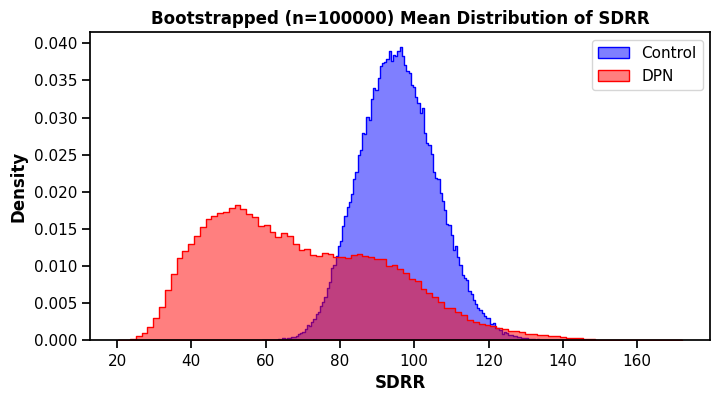

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,RMSSD,0.1993,65.240726,30.541402,94.43762,13.229884


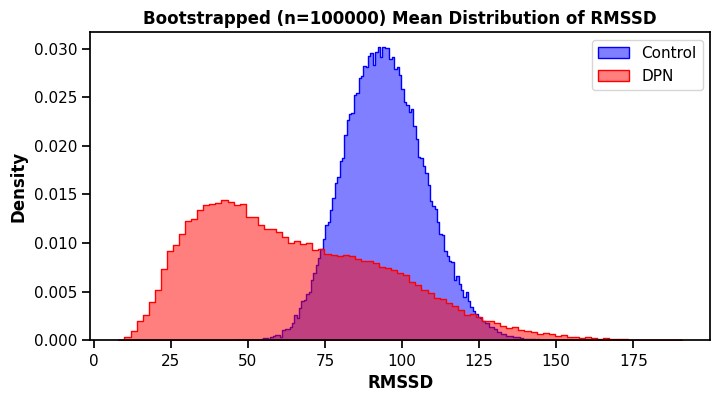

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,pNN50 (%),0.1481,7.432061,5.470903,14.534871,3.031986


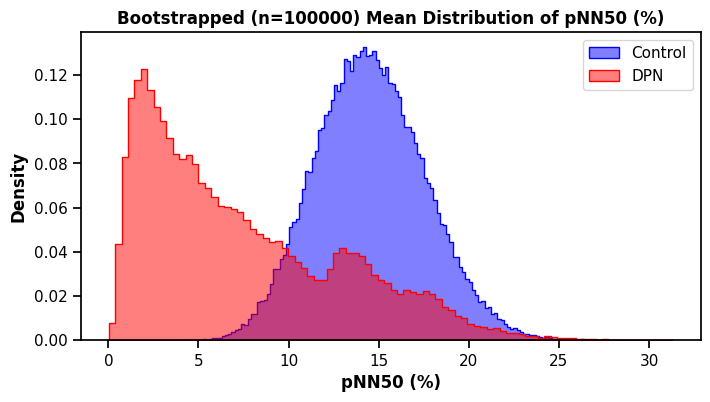

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,Mean HR (bpm),0.17668,81.029476,4.892254,75.931363,2.017484


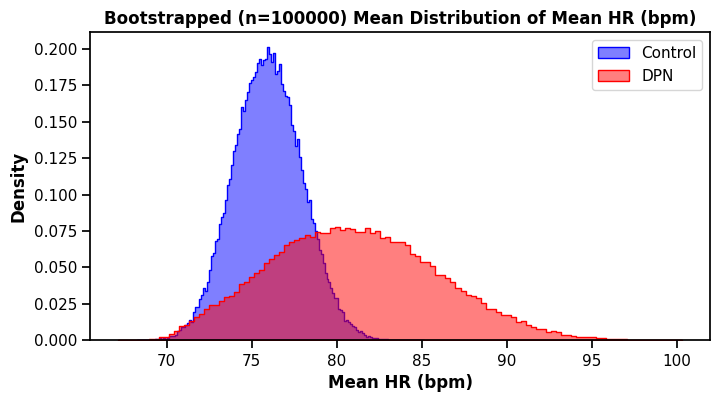

In [20]:
sampler.show_bayes_metrics(time_metrics)

### Bootstrapped Frequency Metrics

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,Peak Frequency,0.29098,0.343496,0.02404,0.329107,0.011482


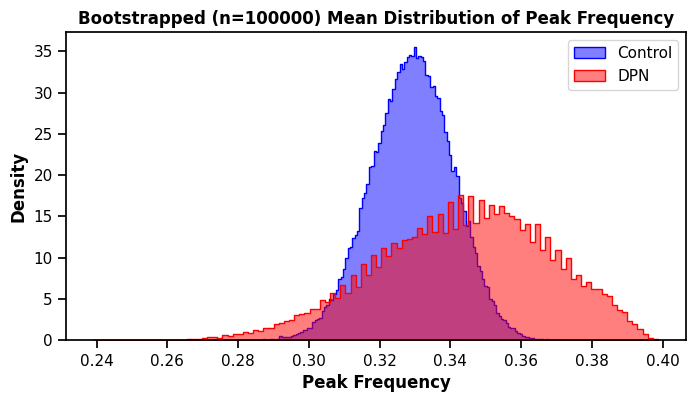

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,Peak Power,0.12978,0.000413,0.000109,0.000554,0.000054


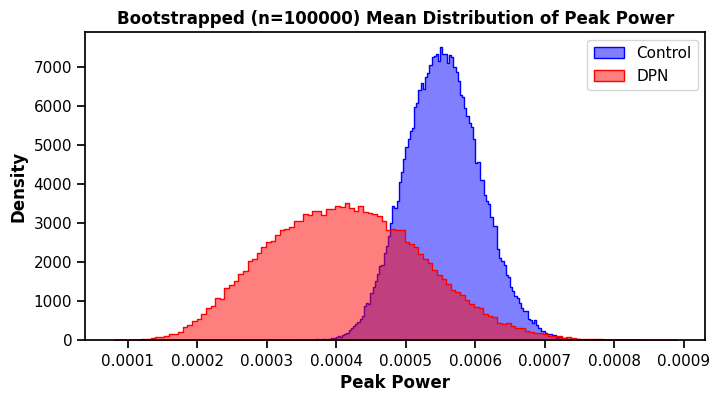

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,VLF Power,0.32205,0.000008,0.000009,0.000009,0.000003


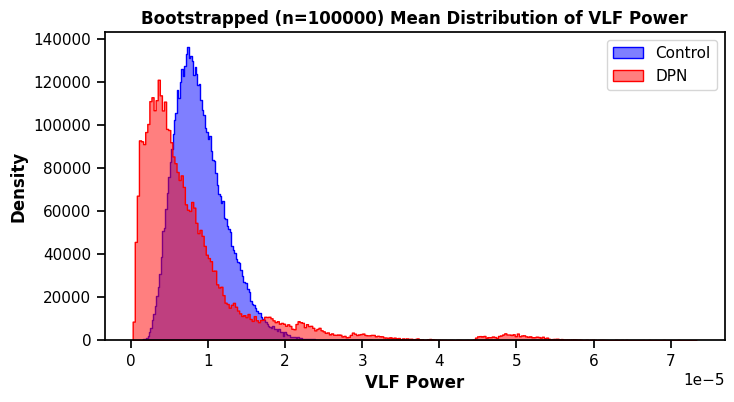

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,VLF Peak Frequency,0.34998,0.028561,0.003891,0.030352,0.001421


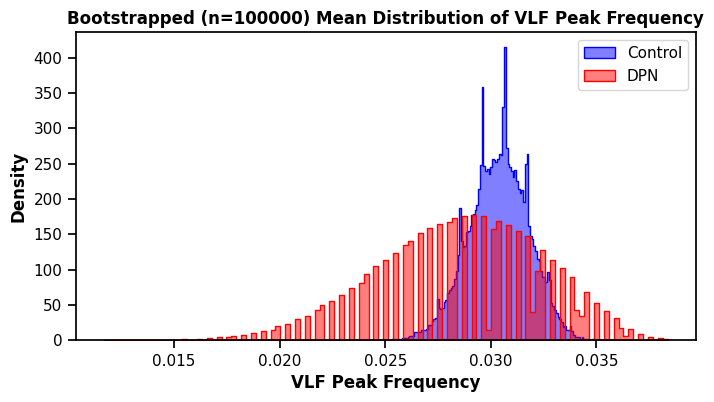

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,LF Power,0.09846,0.000037,0.000015,0.000062,0.000012


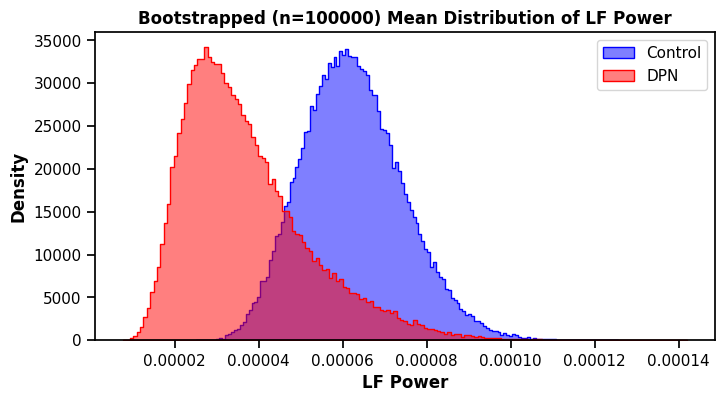

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,LF Peak Frequency,0.36514,0.10558,0.017129,0.112395,0.006162


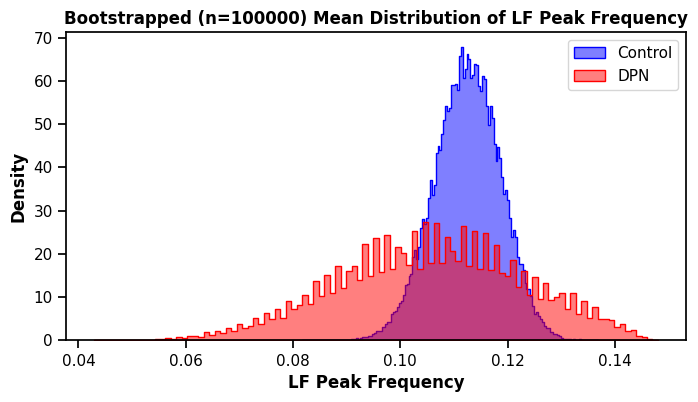

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,HF Power,0.13088,0.000413,0.00011,0.000554,0.000053


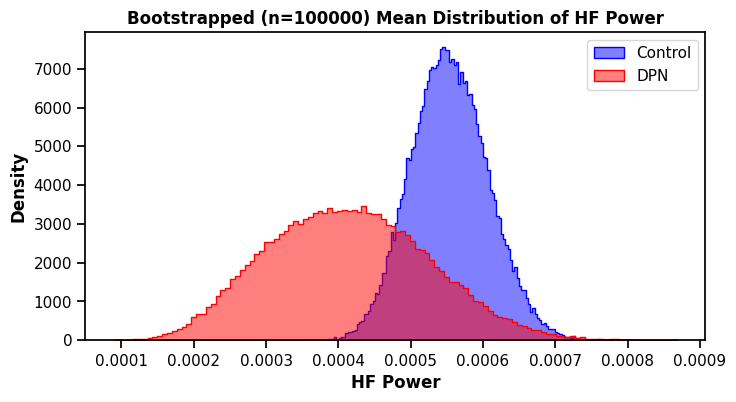

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,HF Peak Frequency,0.29603,0.343497,0.024038,0.329438,0.011287


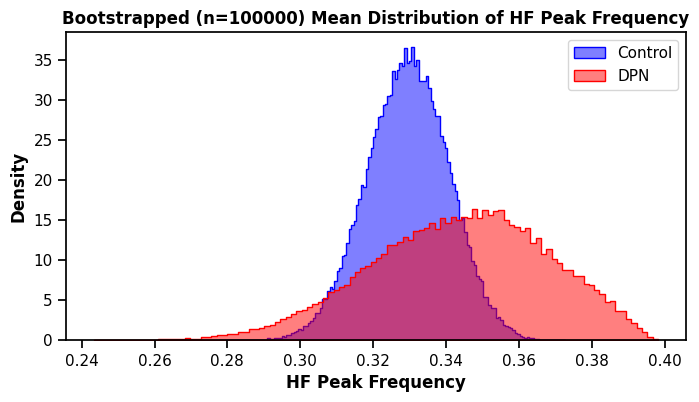

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,LF÷HF Ratio,0.32343,0.107704,0.044441,0.124997,0.025022


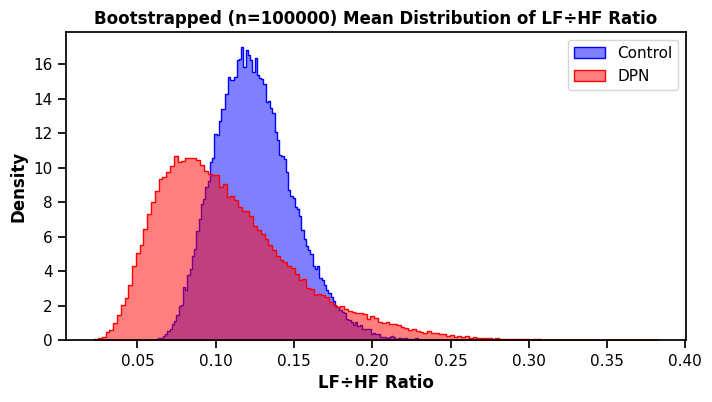

In [21]:
sampler.show_bayes_metrics(frequency_metrics)

There are significant issues with LF HF frequency calculation, as indicated by discontinuous means. 

### Bootstrapped Non Linear Metrics

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,S,0.26088,22468.499727,18602.666149,34612.855091,8901.378751


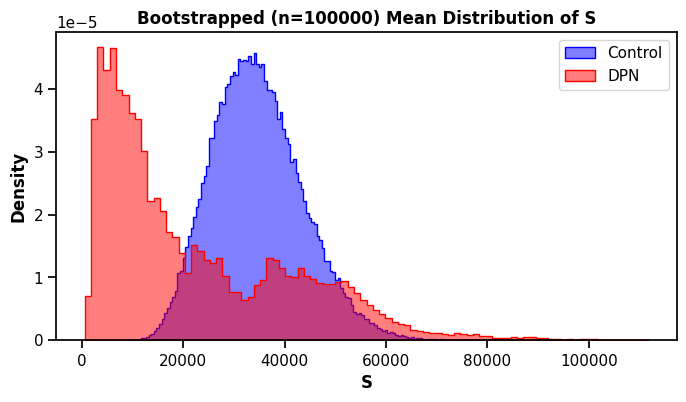

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,SD1,0.20091,46.168469,21.715501,66.825748,9.387679


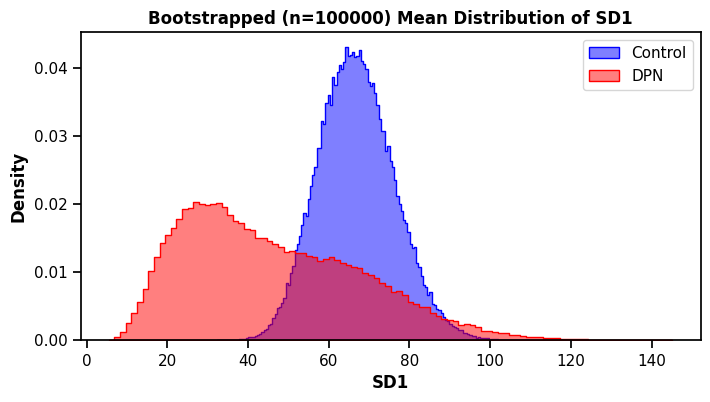

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,SD2,0.16071,84.786252,26.741709,115.507525,11.566602


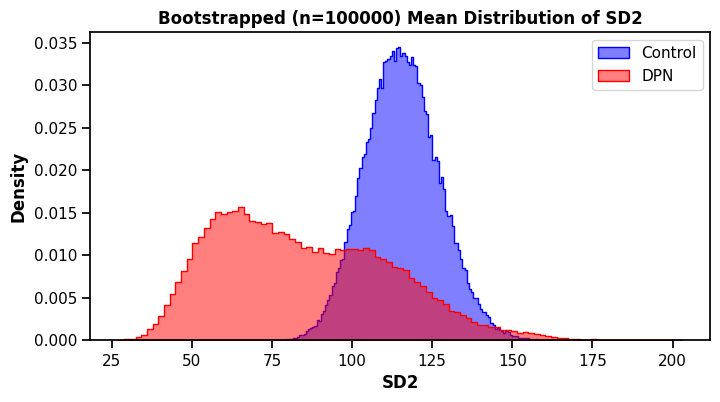

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,SD1÷SD2,0.25952,0.457812,0.101609,0.527866,0.038786


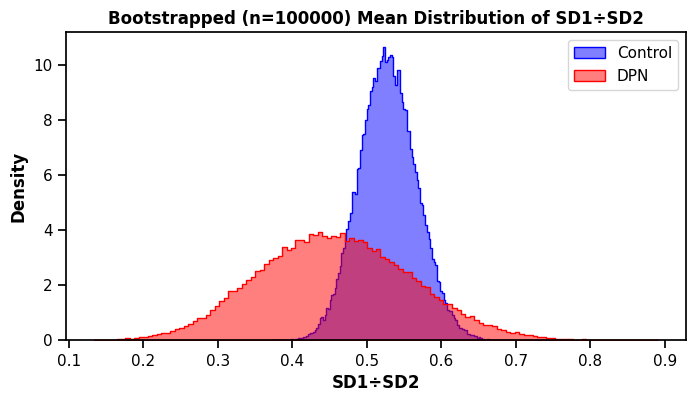

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,ApEn,0.25787,0.782254,0.128888,0.871161,0.046828


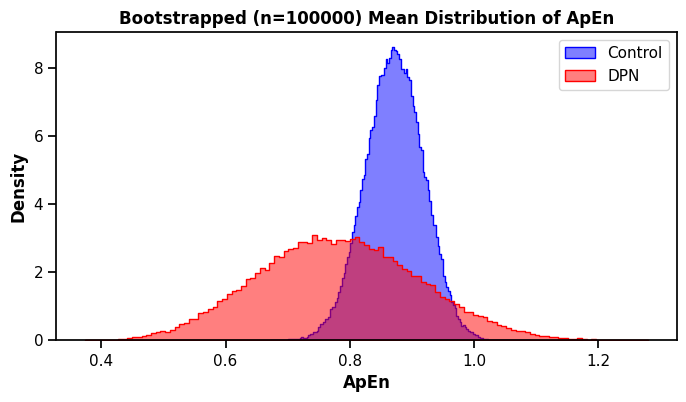

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,SampEn,0.28199,0.732942,0.150755,0.824263,0.060496


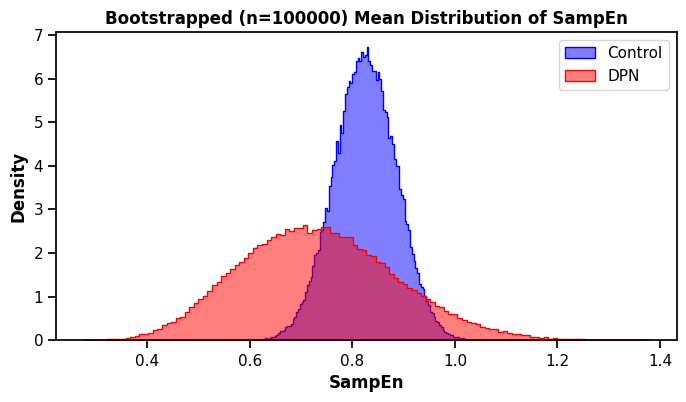

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,DFA α1,0.45591,0.931731,0.131755,0.912915,0.043205


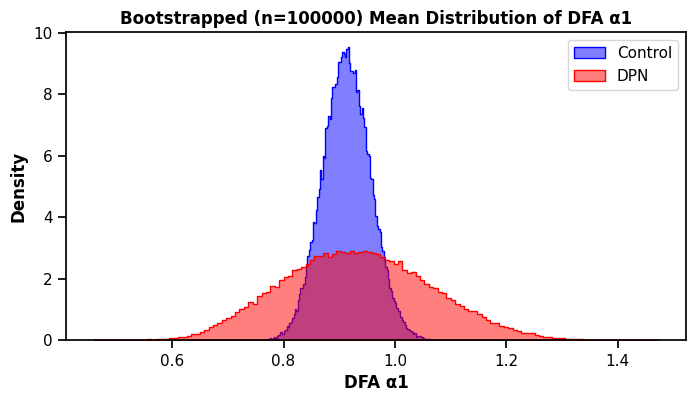

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,DFA α2,0.2142,0.957269,0.127916,0.850083,0.042879


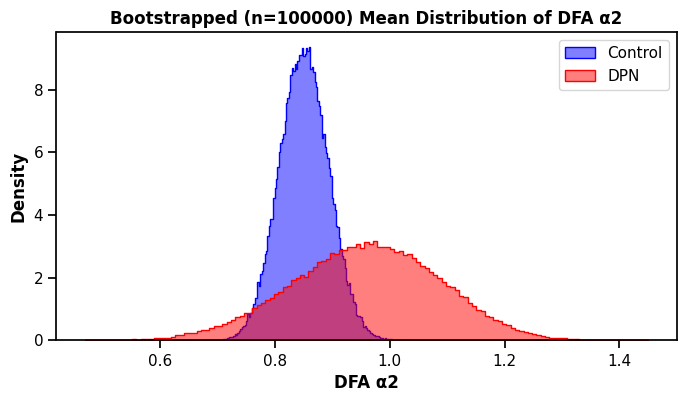

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,D2,0.38764,-3.37726,0.903123,-3.033653,0.289952


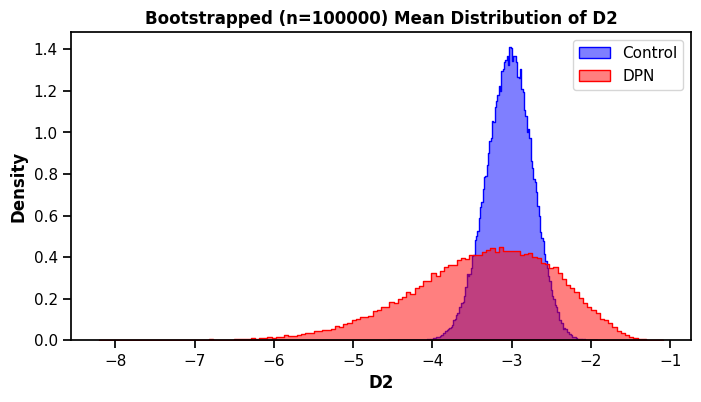

In [22]:
sampler.show_bayes_metrics(non_linear_metrics)

# Dumb classifier approach

this has yielded no good results

I have an idea that checking how suitable each value is for each population would allow me to classify the data

Construct a model that could tell how likely is each value to belong to one of the two pupulations.

Fit a gaussian model onto of each distribution.

In [23]:
from scipy.stats import norm

gaussian_dpn = {}
gaussian_controls ={}

for row in bayes_table.iterrows():
    metric = row[1]['Metric']

    dpn_mean = row[1]['DPN_Mean']
    dpn_std = row[1]['DPN_Std']
    gaussian_dpn[metric] = norm(dpn_mean, dpn_std)

    control_mean = row[1]['Control_Mean']
    control_std = row[1]['Control_Std']
    gaussian_controls[metric] = norm(control_mean, control_std)


calculate the chances of each value belonging to the distribution

In [24]:
chances = pd.DataFrame()
for row in data.iterrows():
  
    chance_dpn = {"x_"+metric: gaussian_dpn[metric].pdf(row[1][metric]) for metric in indicator_columns}

    chance_control = {"c_"+metric: gaussian_controls[metric].pdf(row[1][metric]) for metric in indicator_columns}
    
    chance_dpn = pd.Series(chance_dpn)
    chance_control = pd.Series(chance_control)

    result = {
        'DPN': row[1]['DPN'],
        'DPN_chance': chance_dpn.prod(),
        'control_chance': chance_control.prod(),
        **chance_dpn,
        **chance_control
    }


    chances = pd.concat([chances, pd.DataFrame([result])], ignore_index=True)

chances.tail()

,DPN,DPN_chance,control_chance,x_SDRR,x_RMSSD,x_pNN50 (%),x_Mean HR (bpm),x_Peak Frequency,x_Peak Power,x_VLF Power,...,c_LF÷HF Ratio,c_S,c_SD1,c_SD2,c_SD1÷SD2,c_ApEn,c_SampEn,c_DFA α1,c_DFA α2,c_D2
2604,True,3.496687e-14,4.552328e-100,0.010234,3.968650e-03,0.033314,0.052213,3.673947,490.272501,2522.072372,...,0.002907,6.797289e-08,2.727433e-09,1.240233e-06,5.440190e-15,3.211880e-03,1.435218e-03,5.950550e-09,2.800864e-07,1.496010e-05
2605,True,2.043535e+00,4.394292e-80,0.009876,5.732546e-03,0.061504,0.080589,1.387616,2498.360675,40276.789173,...,3.077350,9.976497e-08,7.142763e-08,4.300941e-07,6.170001e-07,1.865557e-07,1.032150e-08,5.891878e-01,6.177138e-07,1.095394e-13
2606,True,3.592120e-12,6.161965e-126,0.008057,7.767214e-03,0.043184,0.062844,3.730127,63.214990,36611.534722,...,0.051510,1.177621e-07,1.358121e-06,9.134828e-09,2.768588e+00,2.303117e-27,2.109634e-27,3.817174e+00,1.601764e-11,5.570002e-19
2607,True,1.833939e+03,4.323689e-42,0.012095,7.148662e-03,0.046592,0.077008,2.830854,1223.245208,38758.851046,...,7.359395,6.407802e-07,5.881997e-07,2.785091e-02,5.770143e-17,2.384438e+00,5.880649e+00,3.022641e-01,7.974170e-13,5.152345e-03
2608,True,1.181279e-25,3.914710e-137,0.000001,3.365971e-08,0.001887,0.035717,2.867194,2126.499221,33116.914778,...,0.023154,2.074528e-14,1.474877e-21,3.244599e-11,5.885791e-12,6.668133e-16,3.391141e-17,2.769482e-05,9.290883e+00,3.685007e-12


In [25]:
chances["shows_dpn"] = chances["DPN_chance"] > chances["control_chance"]

chances["true_positive"] = chances["shows_dpn"] & chances["DPN"]
chances["false_positive"] = chances["shows_dpn"] & ~chances["DPN"]
chances["true_negative"] = ~chances["shows_dpn"] & ~chances["DPN"]
chances["false_negative"] = ~chances["shows_dpn"] & chances["DPN"]


results = {
    "true_positive": chances["true_positive"].mean(),
    "true_negative": chances["true_negative"].mean(),
    "false_positive": chances["false_positive"].mean(),
    "false_negative": chances["false_negative"].mean()
}

print(results)

{'true_positive': 0.14603296282100423, 'true_negative': 0.0019164430816404753, 'false_positive': 0.8520505940973553, 'false_negative': 0.0}


In [26]:
for metric in indicator_columns:
    chances[f"x_higher_{metric}"] = chances[f"x_{metric}"] > chances[f"c_{metric}"]


chances["dpn_favoring_metrics_count"] = chances[[f"x_higher_{metric}" for metric in indicator_columns]].sum(axis=1)
chances["control_favoring_metrics_count"] = len(indicator_columns) - chances["dpn_favoring_metrics_count"]


chances["dpn_favor_percentage"] = chances["dpn_favoring_metrics_count"] / len(indicator_columns) * 100
chances["control_favor_percentage"] = chances["control_favoring_metrics_count"] / len(indicator_columns) * 100

metric_counts = {
    "avg_dpn_favoring_metrics": chances["dpn_favoring_metrics_count"].mean(),
    "avg_control_favoring_metrics": chances["control_favoring_metrics_count"].mean(),
    "avg_dpn_favor_percentage": chances["dpn_favor_percentage"].mean(),
    "avg_control_favor_percentage": chances["control_favor_percentage"].mean()
}

print("Average metrics per patient:")
for key, value in metric_counts.items():
    print(f"{key}: {value:.2f}")


print("\nAverage for actual DPN patients:")
print(f"dpn_favoring_metrics: {chances[chances['DPN']]['dpn_favoring_metrics_count'].mean():.2f}")
print(f"control_favoring_metrics: {chances[chances['DPN']]['control_favoring_metrics_count'].mean():.2f}")

print("\nAverage for actual control patients:")
print(f"dpn_favoring_metrics: {chances[~chances['DPN']]['dpn_favoring_metrics_count'].mean():.2f}")
print(f"control_favoring_metrics: {chances[~chances['DPN']]['control_favoring_metrics_count'].mean():.2f}")

Average metrics per patient:
avg_dpn_favoring_metrics: 17.35
avg_control_favoring_metrics: 4.65
avg_dpn_favor_percentage: 78.88
avg_control_favor_percentage: 21.12

Average for actual DPN patients:
dpn_favoring_metrics: 18.19
control_favoring_metrics: 3.81

Average for actual control patients:
dpn_favoring_metrics: 17.21
control_favoring_metrics: 4.79
